In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import camb
import statistics
import hankl

In [2]:
# data_off = '/pscratch/sd/l/lflores/ASTRID/data/spectra_ASTRID_self-shield_off_z2.5_500x500x2500.hdf5'  # Without self-shielding
data_on = '/pscratch/sd/l/lflores/ASTRID/data/spectra_ASTRID_z2.5_500x500x2500.hdf5'  # With self-shielding

with h5py.File(data_on, 'r') as f:
    print('Keys:', f.keys())
    header_on = f['Header']
    print('------ Header ------')
    for attr in header_on.attrs:
            print(f"{attr} : {header_on.attrs[attr]}")
    print('------ Data ------')
    colden = f['colden/H/1'][:]
    print('colden shape:', colden.shape)  

Keys: <KeysViewHDF5 ['Header', 'colden', 'spectra', 'tau']>
------ Header ------
Hz : 252.87249366801257
box : 250000.0
discarded : 0
hubble : 0.6774
nbins : 2500
npart : [165988309584 166375000000            0            0  10297622146
     11325619]
omegab : 0.0486
omegal : 0.6911
omegam : 0.3089
redshift : 2.499999947500001
------ Data ------
colden shape: (250000, 2500)


In [3]:
print('----- Useful information -----')
Lbox = 250  # Mpc/h
print('box size:', Lbox, 'Mpc/h')

# Number of skewers per side
Nsk = int(np.sqrt(colden.shape[0]))  # colden.on_shape[0] gives the size of the axis
print(Nsk,'skewers per side')

# Number of pixels per skewer
Np = colden.shape[1] # colden.on_shape[1] gives the size of the columns
print(Np, 'pixels per skewer')

# Pixel width 
Pw = Lbox/Np  # Mpc/h 
print(Pw, 'Mpc/h pixel width')
# We are dividing the total box width in comoving units by the number of pixels in each skewer

# Minimum separation between skewers
Ssk = Lbox/Nsk  # Mpc/h 
print(Ssk, 'Mpc/h skewer separation')
# We are dividing the total box width in comoving units by the number of skewers per side

----- Useful information -----
box size: 250 Mpc/h
500 skewers per side
2500 pixels per skewer
0.1 Mpc/h pixel width
0.5 Mpc/h skewer separation


# Dark matter

As we will need both the power spectra and the 2pcf for dm, let's calculate them first

## Isotropic power spectrum

In [4]:
from camb import model
hubble, z = 0.6774, 2.5
omegab, omegam = 0.0486, 0.3089  # Using ASTRID simulation parameters
pars = camb.set_params(H0=100*hubble, ombh2=omegab*(hubble**2), omch2=omegam*(hubble**2), ns=0.96)

In [5]:
pars.set_matter_power(redshifts=[z], kmax=100)
pars.NonLinear = model.NonLinear_none  # Linear spectra
results = camb.get_results(pars)
k_dm, z, pk = results.get_linear_matter_power_spectrum(hubble_units=True, k_hunit=True) 
p_dm = pk[0, :]

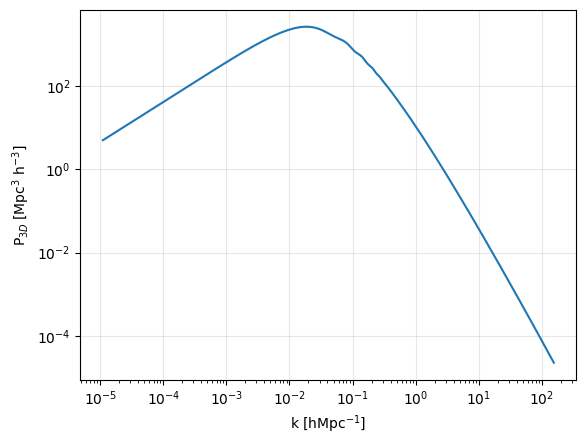

In [6]:
plt.plot(k_dm, p_dm)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'k [hMpc$^{-1}$]')
plt.ylabel(r'P$_{3D}$ [Mpc$^{3}$ h$^{-3}$]')
plt.grid(alpha=0.3);

## Correlation function

In [7]:
k_dm_logspace = np.logspace(np.log10(1e-3), np.log10(k_dm.max()), 100*len(k_dm))
p_dm_logspace = np.interp(k_dm_logspace, k_dm, p_dm)  # To improve the quality of the correlation function

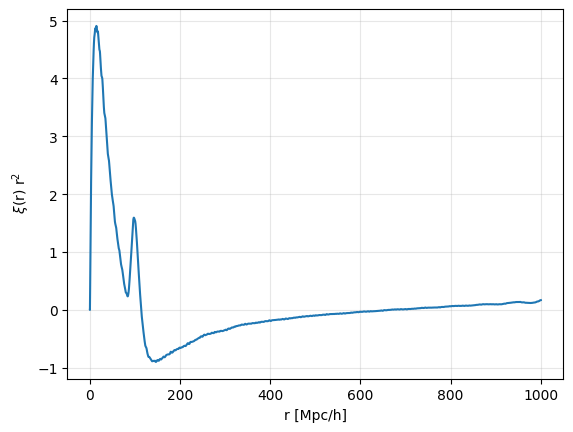

In [8]:
r_dm, dm_2pcf_0 = np.real(hankl.P2xi(k_dm_logspace, p_dm_logspace, l=0))

plt.plot(r_dm, (r_dm**2)*dm_2pcf_0)
plt.xlabel('r [Mpc/h]')
plt.ylabel(r' $\xi$(r) r$^2$')
plt.grid(alpha=0.3);

# ASTRID data

In [9]:
colden[colden<=0] = np.nan  # To avoid problems with logarithms
colden_log = np.log10(colden)
print(colden_log.shape)
del colden

(250000, 2500)


In [10]:
def coord_Mpc_h(colden, colden_min, colden_max, h=0.7, h_units=True):
    """ This functions gives back the coordinates (in Mpc/h if h_units=True) of those systems with a value
    of column density such as colden_min < colden < colden_max

    Parameters:
    ----------------
    colden : narray
        (Log10) Column density values of the simulation box
    colden_min : value
        Lowest limit on (log10) column density values to be considered
    colden_max : value
        Highest limit on (log10) column density values to be considered
    h : value
        Little Hubble constant value
    h_units : Boolean
        Wether we want the returned coordinates to be in units of h or not. By default, True.

    Returns:
    ---------------
    x, y, z : arrays
        Coordinate values in Mpc/h of pixels with column density within the defined range

    """

    Lbox = 250  # Mpc/h
    Nsk, Np = 500, 2500  # Number of skewers in box and number of pixels in each skewer
    Pw = Lbox/Np  # Pixel width in Mpc/h
    Skw = Lbox/Nsk  # Skewer "width" in Mpc/h 
    
    mask = (colden > colden_min) & (colden < colden_max) 
    skewer_idx, z_idx = np.where(mask)
    x_idx = skewer_idx % Nsk  # % Returns remainder of division 
    y_idx = skewer_idx // Nsk  # // Returns floor of division result (largest integer that is less than or equal to the result of the division)

    x = (x_idx + Ssk/2) * Ssk
    y = (y_idx + Ssk/2) * Ssk
    z = (z_idx + Pw/2) * Pw

    if h_units == False:
        x *= h
        y *= h
        z *= h

    return x, y, z

## Power spectrum

### Different HCDs

In [11]:
x_hcd, y_hcd, z_hcd = coord_Mpc_h(colden_log, 19, 22, h=hubble, h_units=True)  # Same Nhi range as in MW11
x_lls, y_lls, z_lls = coord_Mpc_h(colden_log, 17.22, 20, h=hubble, h_units=True)  # Mpc/h
x_subdla, y_subdla, z_subdla = coord_Mpc_h(colden_log, 20, 20.3, h=hubble, h_units=True)  # Mpc/h
x_smalldla, y_smalldla, z_smalldla = coord_Mpc_h(colden_log, 20.3, 21, h=hubble, h_units=True)  # Mpc/h
x_largedla, y_largedla, z_largedla = coord_Mpc_h(colden_log, 21, 22, h=hubble, h_units=True)  # Mpc/h

In [12]:
from nbodykit.lab import *

Boxsize = Lbox  # Mpc/h
dk = 2*np.pi/Boxsize  # Step of k
Nmesh = 244*2  # Increasing this number increases k_max I can trust 

In [13]:
# HCDs
# We first create a catalog with the positions:
cat = ArrayCatalog({'Position': np.c_[x_hcd, y_hcd, z_hcd]})
# From it we create a mesh
mesh = cat.to_mesh(BoxSize=Boxsize, Nmesh=Nmesh, compensated=True, resampler='cic', position='Position')
# Calculate fourier transform
r = FFTPower(mesh, mode='1d', dk=dk)
k_hcd, p3d_hcd = r.power['k'][1:], r.power['power'][1:].real-r.power.attrs['shotnoise']  # First value is a bit skechy

p_dm_interp = np.interp(k_hcd, k_dm, p_dm)
ratio_hcd = p3d_hcd/p_dm_interp

In [14]:
# LLS
cat = ArrayCatalog({'Position': np.c_[x_lls, y_lls, z_lls]})
mesh = cat.to_mesh(BoxSize=Boxsize, Nmesh=Nmesh, compensated=True, resampler='cic', position='Position')
r = FFTPower(mesh, mode='1d', dk=dk)
k_lls, p3d_lls = r.power['k'][1:], r.power['power'][1:].real-r.power.attrs['shotnoise']  # First value is a bit skechy

p_dm_interp = np.interp(k_lls, k_dm, p_dm)
ratio_lls = p3d_lls/p_dm_interp

In [15]:
# subDLAs
cat = ArrayCatalog({'Position': np.c_[x_subdla, y_subdla, z_subdla]})
mesh = cat.to_mesh(BoxSize=Boxsize, Nmesh=Nmesh, compensated=True, resampler='cic', position='Position')
r = FFTPower(mesh, mode='1d', dk=dk)
k_subdla, p3d_subdla = r.power['k'][1:], r.power['power'][1:].real-r.power.attrs['shotnoise']  # First value is skechy

p_dm_interp = np.interp(k_subdla, k_dm, p_dm)
ratio_subdla = p3d_subdla/p_dm_interp

In [16]:
# small DLAs
cat = ArrayCatalog({'Position': np.c_[x_smalldla, y_smalldla, z_smalldla]})
mesh = cat.to_mesh(BoxSize=Boxsize, Nmesh=Nmesh, compensated=True, resampler='cic', position='Position')
r = FFTPower(mesh, mode='1d', dk=dk)
k_smalldla, p3d_smalldla = r.power['k'][1:], r.power['power'][1:].real-r.power.attrs['shotnoise']  # First value is a bit skechy

p_dm_interp = np.interp(k_smalldla, k_dm, p_dm)
ratio_smalldla = p3d_smalldla/p_dm_interp

In [17]:
# Large DLAs
cat = ArrayCatalog({'Position': np.c_[x_largedla, y_largedla, z_largedla]})
mesh = cat.to_mesh(BoxSize=Boxsize, Nmesh=Nmesh, compensated=True, resampler='cic', position='Position')
r = FFTPower(mesh, mode='1d', dk=dk)
k_largedla, p3d_largedla = r.power['k'][1:], r.power['power'][1:].real-r.power.attrs['shotnoise']  # First value is a bit skechy

p_dm_interp = np.interp(k_largedla, k_dm, p_dm)
ratio_largedla = p3d_largedla/p_dm_interp

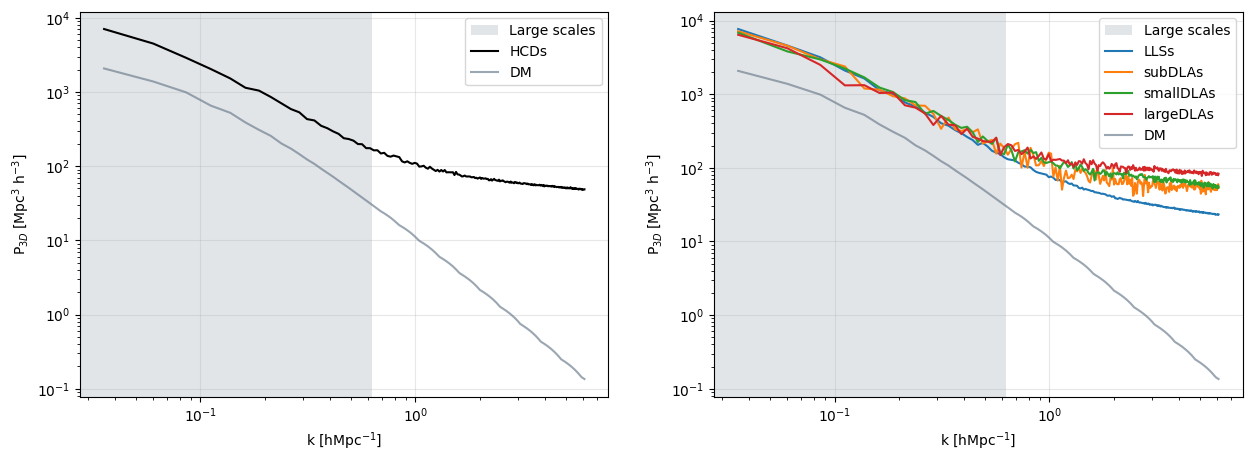

In [18]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.axvspan(0, 2*np.pi/10, facecolor='slategrey', alpha=0.2, label='Large scales')
plt.plot(k_hcd, p3d_hcd, color='k', label='HCDs')
plt.plot(k_hcd, p_dm_interp, color='slategrey', alpha=0.7, label='DM')
plt.xscale('log')
plt.yscale('log')
plt.grid(alpha=0.3)
plt.xlabel(r'k [hMpc$^{-1}$]')
plt.ylabel(r'P$_{3D}$ [Mpc$^{3}$ h$^{-3}$]')
plt.legend();

plt.subplot(1, 2, 2)
plt.axvspan(0, 2*np.pi/10, facecolor='slategrey', alpha=0.2, label='Large scales')
plt.plot(k_lls, p3d_lls, label='LLSs')
plt.plot(k_subdla, p3d_subdla, label='subDLAs')
plt.plot(k_smalldla, p3d_smalldla, label='smallDLAs')
plt.plot(k_largedla, p3d_largedla, label='largeDLAs')
plt.plot(k_hcd, p_dm_interp, color='slategrey', alpha=0.7, label='DM')
plt.xscale('log')
plt.yscale('log')
plt.grid(alpha=0.3)
plt.xlabel(r'k [hMpc$^{-1}$]')
plt.ylabel(r'P$_{3D}$ [Mpc$^{3}$ h$^{-3}$]')
plt.legend();

In [19]:
bias_hcd = np.sqrt(ratio_hcd)
bias_lls = np.sqrt(ratio_lls)
bias_subdla = np.sqrt(ratio_subdla)
bias_smalldla = np.sqrt(ratio_smalldla)
bias_largedla = np.sqrt(ratio_largedla)

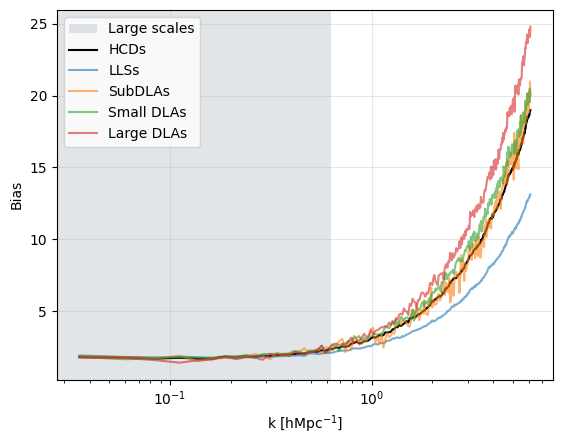

In [20]:
plt.axvspan(0, 2*np.pi/10, facecolor='slategrey', alpha=0.2, label='Large scales')
plt.plot(k_hcd, bias_hcd, color='k', label='HCDs')
plt.plot(k_lls, bias_lls, alpha=0.6, label='LLSs')
plt.plot(k_subdla, bias_subdla, alpha=0.6, label='SubDLAs')
plt.plot(k_smalldla, bias_smalldla, alpha=0.6, label='Small DLAs')
plt.plot(k_largedla, bias_largedla, alpha=0.6, label='Large DLAs')
plt.xscale('log')
plt.grid(alpha=0.3)
plt.xlabel(r'k [hMpc$^{-1}$]')
plt.ylabel(r'Bias')
plt.legend();

As this is a large-scale bias, we only want to keep values for r > 10 Mpc => k < 2pi/10 h/Mpc 

In [21]:
mask_hcd = (k_hcd < (2*np.pi/10)) 
mask_lls = (k_lls < (2*np.pi/10)) 
mask_subdla = (k_subdla < (2*np.pi/10)) 
mask_smalldla = (k_smalldla < (2*np.pi/10)) 
mask_largedla = (k_largedla < (2*np.pi/10)) 

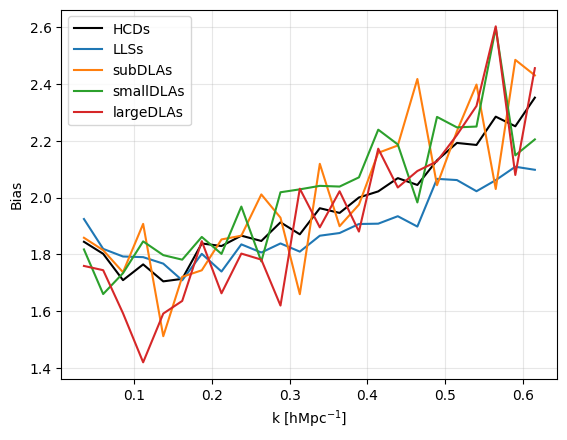

In [22]:
plt.plot(k_hcd[mask_hcd], np.sqrt(ratio_hcd[mask_hcd]), color='k', label='HCDs')
plt.plot(k_lls[mask_lls], np.sqrt(ratio_lls[mask_lls]), label='LLSs')
plt.plot(k_subdla[mask_subdla], np.sqrt(ratio_subdla[mask_subdla]), label='subDLAs')
plt.plot(k_smalldla[mask_smalldla], np.sqrt(ratio_smalldla[mask_smalldla]), label='smallDLAs')
plt.plot(k_largedla[mask_largedla], np.sqrt(ratio_largedla[mask_largedla]), label='largeDLAs')
plt.grid(alpha=0.3)
plt.xlabel(r'k [hMpc$^{-1}$]')
plt.ylabel(r'Bias')
plt.legend();

In [23]:
bias_hcd, bias_hcd_std = np.nanmean(bias_hcd[mask_hcd]), np.nanstd(bias_hcd[mask_hcd])
bias_lls, bias_lls_std = np.nanmean(bias_lls[mask_lls]), np.nanstd(bias_lls[mask_lls])
bias_subdla, bias_subdla_std = np.nanmean(bias_subdla[mask_subdla]), np.nanstd(bias_subdla[mask_subdla])
bias_smalldla, bias_smalldla_std = np.nanmean(bias_smalldla[mask_smalldla]), np.nanstd(bias_smalldla[mask_smalldla])
bias_largedla, bias_largedla_std = np.nanmean(bias_largedla[mask_largedla]), np.nanstd(bias_largedla[mask_largedla])
print('HCDs bias=', bias_hcd, '+-', bias_hcd_std)
print('LLSs bias=', bias_lls, '+-', bias_lls_std)
print('Sub-dlas bias=', bias_subdla, '+-', bias_subdla_std)
print('Small DLAs bias=', bias_smalldla, '+-', bias_smalldla_std)
print('Large DLAs bias=', bias_largedla, '+-', bias_largedla_std)

HCDs bias= 1.964040305040265 +- 0.18619998481765154
LLSs bias= 1.8930029169424774 +- 0.11637370008979467
Sub-dlas bias= 1.9991548356076574 +- 0.2558593387633578
Small DLAs bias= 2.015717422434702 +- 0.22034125233264856
Large DLAs bias= 1.9328845762419726 +- 0.2888552549084233


## Comparison with correlation function -obtained bias

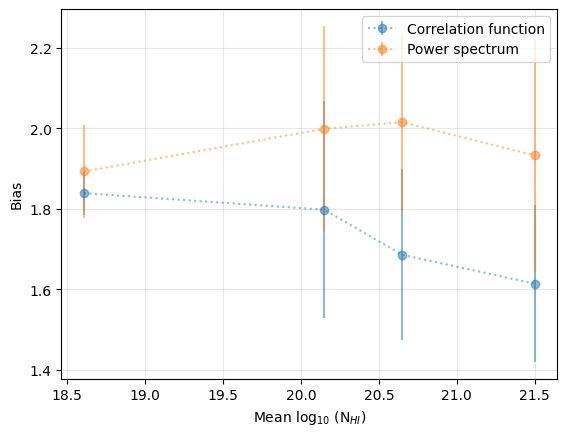

In [24]:
mean_colden = [18.61, 20.15, 20.65, 21.5]
y_power = [bias_lls, bias_subdla, bias_smalldla, bias_largedla]
yerr_power = [bias_lls_std, bias_subdla_std, bias_smalldla_std, bias_largedla_std]
y_corrfunc = [1.8390609146303727, 1.7980176538547112, 1.6858185659151192, 1.6140292749946834]
yerr_corrfunc = [0.05315677834638494, 0.2700419402340387, 0.2127713655974928, 0.19458528639062198]
plt.errorbar(mean_colden, y=y_corrfunc, yerr=yerr_corrfunc, linestyle='dotted', marker='o', alpha=0.5, label='Correlation function')
plt.errorbar(mean_colden, y=y_power, yerr=yerr_power, linestyle='dotted', marker='o', alpha=0.5, label='Power spectrum')
plt.xlabel(r'Mean log$_{10}$ (N$_{HI}$)')
plt.ylabel('Bias')
plt.grid(alpha=0.3)
plt.legend();